In [293]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance

In [133]:
path = '../data/Jan_09/'
fire = pd.read_csv(path + 'Historical_Wildfire_fill0_new.csv')
weather = pd.read_csv(path + 'HistoricalWeather.csv')

In [388]:
def pivot_weather(w):
    w = w.copy()
    w = w.rename(columns = {'max()': 'max', 'min()': 'min', 'mean()': 'mean'})
    w = w.pivot_table(columns = 'Parameter', 
                      index = ['Date', 'Region'],
                      values = ['min', 'max', 'mean'])
    w.reset_index(inplace = True)
    w.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in w.columns.values]
    return w

def combine_data(f, w):
    f = f.copy()
    w = w.copy()
    w = pivot_weather(w)
    data = pd.merge(f[['Date', 'Region', 'Estimated_fire_area']], w, on = ['Date', 'Region'])
    data['Safe'] = (data['Estimated_fire_area'] == 0).astype(int)
    data = data.set_index('Date')
    data = data.dropna()
    return data

def prepare(data, region, lag = 7, period = 15):
    data = data.copy()
    data = data[data['Region'] == region]
    data = data[['Safe', 'Estimated_fire_area', 'SolarRadiation_max', 'SolarRadiation_min', 'SolarRadiation_mean', 'SoilWaterContent_max', 'SoilWaterContent_min', 'SoilWaterContent_mean']]
    data['Safe'] = data['Safe'].astype('category')
    
    for i in range(period):
        data[f'Prev_fire_area_{i}'] = data['Estimated_fire_area'].shift(lag+i)
    data = data[period+lag:]
    data = data.drop(['Estimated_fire_area'], axis = 1)
    
    data['Month'] = pd.to_datetime(data.index).month
    
    return data

In [389]:
data = combine_data(fire, weather)

for reg in regions:
    df = prepare(data, region = reg)
    df.to_csv(f'../data/safe/{reg}.csv')

In [367]:
df = prepare(data, 'NSW')
    
X, y = df.drop('no', axis = 1), df['no']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, shuffle = True)
    
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'objective': 'binary:logistic'
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy

In [373]:
import optuna

study = optuna.create_study()
study.optimize(objective,n_trials=10)

[I 2021-01-13 18:08:53,110] A new study created in memory with name: no-name-b6317733-4fe8-422b-a061-093d583846fb


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 18:08:53,400] Trial 0 finished with value: 0.8442906574394463 and parameters: {'n_estimators': 537, 'max_depth': 12, 'learning_rate': 0.06441369915540854, 'subsample': 0.795484711012629, 'colsample_bytree': 0.5822594284035973, 'gamma': 8}. Best is trial 0 with value: 0.8442906574394463.
[I 2021-01-13 18:08:53,568] Trial 1 finished with value: 0.8477508650519031 and parameters: {'n_estimators': 413, 'max_depth': 16, 'learning_rate': 0.0628308054416292, 'subsample': 0.5023372283963035, 'colsample_bytree': 0.8536619768861549, 'gamma': 6}. Best is trial 0 with value: 0.8442906574394463.


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 18:08:53,858] Trial 2 finished with value: 0.8350634371395617 and parameters: {'n_estimators': 562, 'max_depth': 19, 'learning_rate': 0.057809938109588566, 'subsample': 0.8338140047167943, 'colsample_bytree': 0.843504998103638, 'gamma': 0}. Best is trial 2 with value: 0.8350634371395617.
[I 2021-01-13 18:08:54,013] Trial 3 finished with value: 0.842560553633218 and parameters: {'n_estimators': 530, 'max_depth': 14, 'learning_rate': 0.07238264777356158, 'subsample': 0.7973199169374559, 'colsample_bytree': 0.5007874860241877, 'gamma': 9}. Best is trial 2 with value: 0.8350634371395617.


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 18:08:54,164] Trial 4 finished with value: 0.8437139561707035 and parameters: {'n_estimators': 417, 'max_depth': 15, 'learning_rate': 0.08764975219477278, 'subsample': 0.5844297365349467, 'colsample_bytree': 0.675883428224566, 'gamma': 10}. Best is trial 2 with value: 0.8350634371395617.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 18:08:54,609] Trial 5 finished with value: 0.8483275663206459 and parameters: {'n_estimators': 566, 'max_depth': 15, 'learning_rate': 0.09102133620203909, 'subsample': 0.8116508670337998, 'colsample_bytree': 0.7318541294458641, 'gamma': 9}. Best is trial 2 with value: 0.8350634371395617.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 18:08:54,841] Trial 6 finished with value: 0.825836216839677 and parameters: {'n_estimators': 474, 'max_depth': 16, 'learning_rate': 0.09618539462707716, 'subsample': 0.9692709408388558, 'colsample_bytree': 0.9652105230288367, 'gamma': 0}. Best is trial 6 with value: 0.825836216839677.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-01-13 18:08:55,213] Trial 7 finished with value: 0.8431372549019608 and parameters: {'n_estimators': 512, 'max_depth': 13, 'learning_rate': 0.07717993155987116, 'subsample': 0.968228854411284, 'colsample_bytree': 0.5865087240883982, 'gamma': 5}. Best is trial 6 with value: 0.825836216839677.
[I 2021-01-13 18:08:55,366] Trial 8 finished with value: 0.8419838523644751 and parameters: {'n_estimators': 581, 'max_depth': 20, 'learning_rate': 0.05759810962033848, 'subsample': 0.9770794247128916, 'colsample_bytree': 0.5017206090296363, 'gamma': 8}. Best is trial 6 with value: 0.825836216839677.


[18:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:08:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cas

[I 2021-01-13 18:08:55,513] Trial 9 finished with value: 0.8471741637831603 and parameters: {'n_estimators': 407, 'max_depth': 18, 'learning_rate': 0.034795323624327724, 'subsample': 0.8203250034200062, 'colsample_bytree': 0.7572103245376153, 'gamma': 9}. Best is trial 6 with value: 0.825836216839677.


In [374]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.825836216839677, params {'n_estimators': 474, 'max_depth': 16, 'learning_rate': 0.09618539462707716, 'subsample': 0.9692709408388558, 'colsample_bytree': 0.9652105230288367, 'gamma': 0}


In [358]:
best_params = study.best_trial.params
best_params['objective'] = 'binary:logistic'

In [359]:
# Fit the XGBoost classifier with optimal hyperparameters
clf = xgb.XGBClassifier(**best_params)
clf.fit(X_train, y_train)

[18:00:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5071606008495954, gamma=3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.08554437725880452, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=415, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9671433220891672, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [372]:
y_pred = clf.predict(X_valid)
f1_score(y_pred, y_valid)

0.8442367601246106

In [371]:
y_pred = clf.predict(X_train)
f1_score(y_pred, y_train)

0.8500999333777481

(array([1499.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         235.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

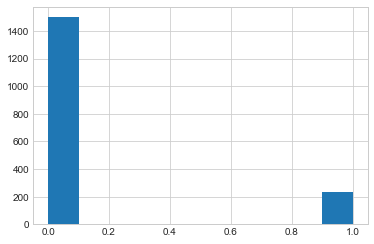

In [361]:
plt.hist(y_test)

(array([1532.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         202.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

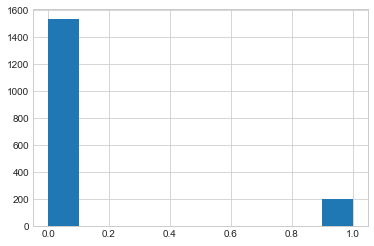

In [362]:
plt.hist(clf.predict(X_test))